In [2]:
import pyBigWig
import pandas as pd
import sys
sys.path.append('/home/hsher/rbp-maps/maps/')
from density.ReadDensity import ReadDensity
import os
from waveform import *
from pybedtools import BedTool
import matplotlib.pyplot as plt
basedir = '/home/hsher/seqdata/eclip_raw/'

In [3]:
# load all ribosome data
neg = basedir + 'ENCFF766RBQ.bigWig'
pos = basedir + 'ENCFF984MNA.bigWig'
bam = basedir + 'ENCFF959SXJ.bam'
RPS3 = ReadDensity(pos, neg, bam = bam, name = 'RPS3')

In [4]:
neg = basedir + 'ENCFF376NMQ.bigWig'
pos = basedir + 'ENCFF142OTS.bigWig'
bam = basedir + 'ENCFF896PKL.bam'
RPS11 = ReadDensity(pos, neg, bam = bam, name = 'RPS11')

In [5]:
# load IDR peaks as goldstandard
in_dir = '/home/hsher/seqdata/eclip_bed/' 
RPS3_uid = 540
RPS11_uid = 614
RPS3_idr = BedTool(in_dir + str(RPS3_uid)+'.01v02.IDR.out.0102merged.bed.blacklist_removed.bed.narrowPeak.bed')
RPS11_idr = BedTool(in_dir + str(RPS11_uid)+'.01v02.IDR.out.0102merged.bed.blacklist_removed.bed.narrowPeak.bed')

In [6]:
# find regions that have peaks

# these are the exons that we use
all_genomic_feature = BedTool('/home/hsher/projects/gencode_exon.gff3')

# we are gonna figure out which of them have peaks
rps3_exon = all_genomic_feature.intersect(RPS3_idr, wa = True, s= True)
rps11_exon = all_genomic_feature.intersect(RPS11_idr, wa = True, s= True)

In [7]:
len(rps3_exon) # 5601 exon has RPS3 IDR peaks

5601

In [8]:
len(rps11_exon) # 28 exons has RPS11 IDR peaks

28

In [9]:
# also find negative examples
no_rps3_exon = all_genomic_feature.intersect(RPS3_idr, wa = True, s= True, v = True)
no_rps11_exon = all_genomic_feature.intersect(RPS11_idr, wa = True, s= True, v = True)

In [10]:
len(no_rps3_exon)

286277

In [11]:
len(no_rps11_exon)

289530

In [12]:
# filter those with no reads
# awk '{ if ($10 > 0 && $13 > 0.005){print}}' RBP.coverage > RBP.noempty
RPS3_noempty = BedTool('/home/hsher/projects/RPS3.noempty')
RPS11_noempty = BedTool('/home/hsher/projects/RPS11.noempty')

In [13]:
no_rps3_exon_filtered = no_rps3_exon.intersect(RPS3_noempty, wa = True, s = True)
no_rps11_exon_filtered = no_rps11_exon.intersect(RPS11_noempty, wa = True, s = True)

In [14]:
len(no_rps3_exon_filtered)

141591

In [15]:
len(no_rps11_exon_filtered)

109522

# Plotting

Text(0.5, 0.98, 'RPS3 read density at exon')

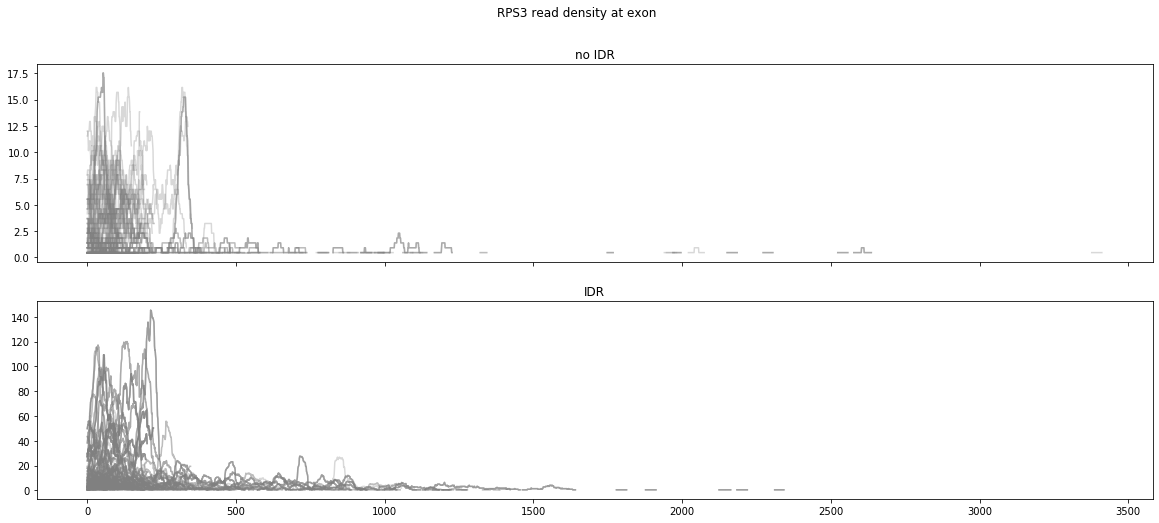

In [21]:
def plot_waveform_flat(key_transcript, read_density, is_smooth = False, window_len = None, sharex = True, ax = plt):
    if len(key_transcript)< 200:
        n = len(key_transcript)
    else: 
        n = 200
        
    for i in range(n):
        chro = key_transcript[i].chrom
        start = int(key_transcript[i].start)
        end = int(key_transcript[i].stop)
        strand = key_transcript[i].strand
    
        shape = read_density.values(chro, start, end, strand)
        if strand == '-':
            shape = [-s for s in shape]
        if is_smooth:
            ax.plot(smooth(shape, window_len = window_len))
        else:
            ax.plot(shape, color = 'grey', alpha = 0.3)
        
f, ax = plt.subplots(2,1, figsize = (20,8), sharex = True)
plot_waveform_flat(no_rps3_exon_filtered, RPS3, ax = ax[0])
plot_waveform_flat(rps3_exon, RPS3, ax = ax[1])
ax[0].set_title('no IDR')
ax[1].set_title('IDR')
plt.suptitle('RPS3 read density at exon')

Text(0.5, 0.98, 'RPS11 read density at exon')

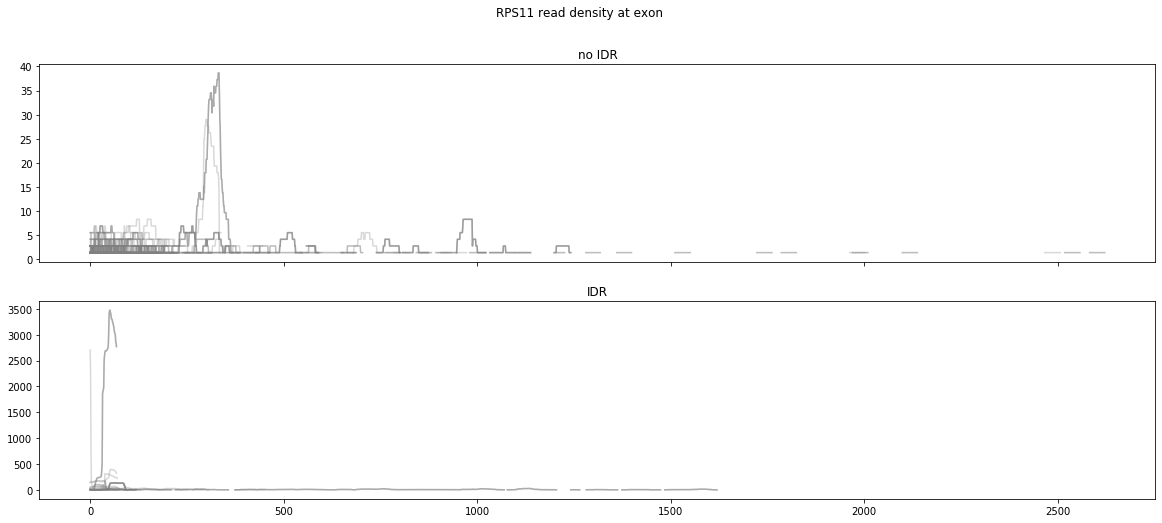

In [22]:
        
f, ax = plt.subplots(2,1, figsize = (20,8), sharex = True)
plot_waveform_flat(no_rps11_exon_filtered, RPS11, ax = ax[0])
plot_waveform_flat(rps11_exon, RPS11, ax = ax[1])
ax[0].set_title('no IDR')
ax[1].set_title('IDR')
plt.suptitle('RPS11 read density at exon')

# Do Fourier Transform on read density (normalized intensity)

In [15]:
from scipy.fft import rfft
def get_spectral(key_transcript, read_density, sample_no = 500):
    all_spect = []
    ids = []
    if len(key_transcript) < sample_no:
        sample = len(key_transcript)
    else:
        sample = sample_no
    for i in range(sample):
        chro = key_transcript[i].chrom
        start = int(key_transcript[i].start)
        end = int(key_transcript[i].stop)
        strand = key_transcript[i].strand
    
        shape = read_density.values(chro, start, end, strand)
        if np.nansum(shape) != 0:
        
            #print(chro, start, end, strand)
            if strand == '-':
                shape = [-s for s in shape]
            shape = np.nan_to_num(shape, 0)
            spect = rfft(shape/np.sum(shape))
            all_spect.append(np.abs(spect))
            ids.append((chro, start, end, strand))
            
        else:
            pass
    return all_spect, ids

In [16]:

yes_rps3, id_yes_rps3 = get_spectral(rps3_exon, RPS3, sample_no = 500)
yes_rps11, id_yes_rps11 = get_spectral(rps11_exon, RPS11, sample_no = 500)
print('done with positive sample')

no_rps3, id_no_rps3 = get_spectral(no_rps3_exon_filtered, RPS3, sample_no = 500)
no_rps11, id_no_rps11 = get_spectral(no_rps11_exon_filtered, RPS3, sample_no = 500)

done with positive sample


In [17]:
def truncate_frequency(group, no_freq = 20):
    ''' truncate frequency feature, and stack up to an np array (sample*no_freq)'''
    return np.stack([a[:no_freq] if len(a)>= no_freq else np.concatenate([a, np.zeros(no_freq-len(a))]) for a in group])
def stacking_data(list_of_freq, labels, list_of_id, no_freq = 20):
    ''' stack up data for PCA or training'''
    all_stacked = []
    all_labels = []
    all_length = []
    for group, label, ids in zip(list_of_freq, labels, list_of_id):
        all_stacked.append(truncate_frequency(group, no_freq = no_freq))
        all_labels += [label]*len(group)
        all_length += [i[2]-i[1] for i in ids]
    X = np.concatenate(all_stacked, axis = 0)
    
    return X, all_labels, all_length

In [18]:
X, labels, lengths = stacking_data([yes_rps3, yes_rps11, no_rps3, no_rps11], 
                                   ['yes_rps3', 'yes_rps11', 'no_rps3', 'no_rps11'],
                                  [id_yes_rps3, id_yes_rps11, id_no_rps3, id_no_rps11])

In [19]:
len(yes_rps3)

500

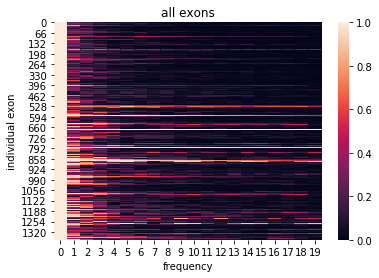

In [20]:
def plot_frequency_map(stacked,name):
    sns.heatmap(stacked)
    plt.xlabel('frequency')
    plt.ylabel('individual exon')
    plt.title(name)
plot_frequency_map(X, 'all exons')

In [21]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(np.nan_to_num(X,0))

In [22]:
color_dict = {'yes_rps3': 'maroon',
             'yes_rps11':'orange',
             'no_rps3': 'aquamarine',
             'no_rps11': 'lightseagreen'}
colors = list(map(lambda x: color_dict[x], labels))

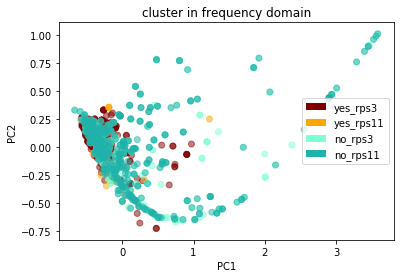

In [23]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = colors, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cluster in frequency domain')

names = list(color_dict.keys())
color_list = list(color_dict.values())

# make legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_list[i], edgecolor=None,
                         label=names[i]) for i in range(len(names))]
plt.legend(handles=legend_elements, loc='right')

In [24]:
import numpy as np
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(np.nan_to_num(X,0))


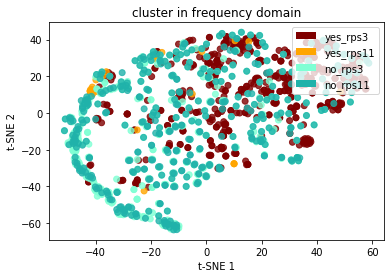

In [25]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = colors, alpha = 0.8)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('cluster in frequency domain')
plt.legend(handles=legend_elements, loc='upper right')

In [26]:
import matplotlib as mpl
import matplotlib.cm as cm

def number_to_color(lengths):
    norm = mpl.colors.Normalize(vmin=min(lengths), vmax=max(lengths))
    cmap = cm.Spectral

    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    seq_length_to_color = [m.to_rgba(x) for x in lengths]
    
    return seq_length_to_color, norm, cmap
seq_length_to_color, norm, cmap = number_to_color(lengths)

Text(0, 0.5, 'intron length')

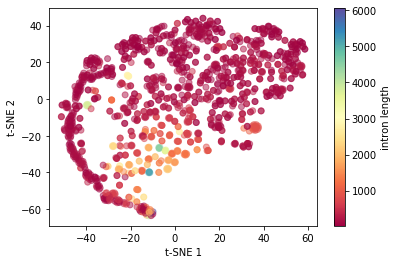

In [27]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = seq_length_to_color, alpha = 0.5)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
cbar.ax.set_ylabel('intron length')

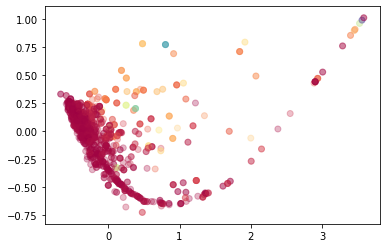

In [28]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = seq_length_to_color, alpha = 0.3)

# normalize truncated frequency

In [29]:
all_norm = X/X.mean(axis =1).reshape(-1,1)

In [30]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.nan_to_num(all_norm,0))

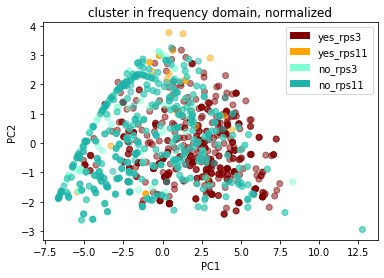

In [31]:
plt.scatter(x = reduced[:,0], y = reduced[:,1], color = colors, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cluster in frequency domain, normalized')
plt.legend(handles=legend_elements, loc='upper right')

In [32]:
X_embedded = TSNE(n_components=2).fit_transform(np.nan_to_num(all_norm,0))

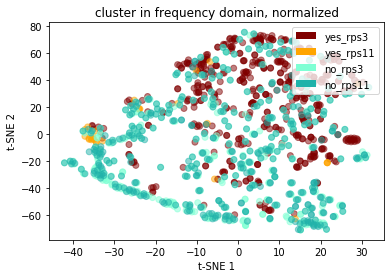

In [33]:
plt.scatter(x = X_embedded[:,0], y = X_embedded[:,1], color = colors, alpha = 0.5)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('cluster in frequency domain, normalized')
plt.legend(handles=legend_elements, loc='upper right')

# Find the "no IDR peak exons" that cluster with "yes IDR exons"

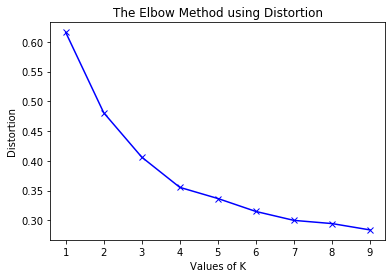

In [34]:
# optimal cluster number by elbow method

from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X) 
    kmeanModel.fit(X)     
      
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / X.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / X.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 


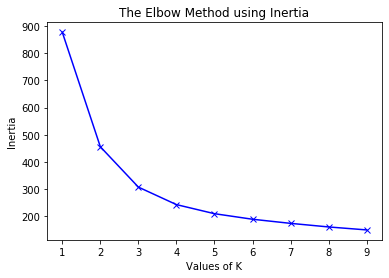

In [35]:

plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 


In [36]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(X)
kmeans.labels_


array([1, 1, 4, ..., 4, 4, 2], dtype=int32)

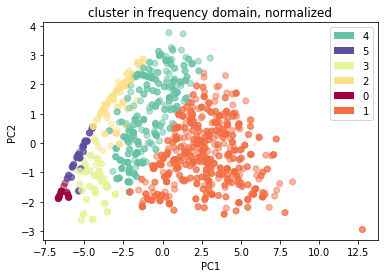

In [37]:
group_color, gr_norm, gr_cmap = number_to_color(kmeans.labels_)
gr_color_dict = dict(set(list(zip(kmeans.labels_, group_color))))
legend_elements = [Patch(facecolor=list(gr_color_dict.values())[i], edgecolor=None,
                         label=list(gr_color_dict.keys())[i]) for i in range(len(gr_color_dict))]

plt.scatter(x = reduced[:,0], y = reduced[:,1], color = group_color, alpha = 0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('cluster in frequency domain, normalized')
plt.legend(handles=legend_elements, loc='upper right')

In [38]:
# statistics of each group
# how many IDR peaks
# how many individual peaks

import pandas as pd
df = pd.DataFrame()
df['group'] = kmeans.labels_
df['IDR'] = labels
df['length'] = lengths
df['genomic pos'] = id_yes_rps3 + id_yes_rps11+id_no_rps3+id_no_rps11

In [40]:
# get peaks from two reps
def get_reps(uID):
    root_dir = '/home/elvannostrand/data/clip/CLIPseq_analysis/ENCODE_FINALforpapers_20180205/hg38/'
    reps = []
    for rep in [1,2]:
        fname = '{0}_0{1}.basedon_{0}_0{1}.peaks.l2inputnormnew.bed.compressed.bed.blacklist_removed.bed'.format(uID, rep)
        r = BedTool(root_dir + fname)
        reps.append(r)
    return reps

In [41]:
reps = get_reps(RPS3_uid)
rps3_rep1 = no_rps3_exon_filtered.intersect(reps[0], wa = True, s= True)
rps3_rep2 = no_rps3_exon_filtered.intersect(reps[1], wa = True, s= True)
reps = get_reps(RPS11_uid)
rps11_rep1 = no_rps11_exon_filtered.intersect(reps[0], wa = True, s= True)
rps11_rep2 = no_rps11_exon_filtered.intersect(reps[1], wa = True, s= True)

In [42]:
def get_exon_in_indv(rep, rep_name, no_sample = 500):
    for i in range(no_sample): # at most 500 of them
        gen_pos = tuple([rep[i].chrom, rep[i].start, rep[i].end, rep[i].strand])
        #print(gen_pos)
        if gen_pos in df['genomic pos'].tolist():
            df.loc[df['genomic pos'] == gen_pos, rep_name] = True

In [43]:
get_exon_in_indv(rps3_rep1, 'rps3_rep1', no_sample = 500)
get_exon_in_indv(rps3_rep2, 'rps3_rep2', no_sample = 500)
get_exon_in_indv(rps11_rep1, 'rps11_rep1', no_sample = 500)
get_exon_in_indv(rps11_rep2, 'rps11_rep2', no_sample = 500)
df.fillna(False, inplace =True)

In [44]:
df.groupby(by = 'group').mean()

,length,rps3_rep1,rps3_rep2,rps11_rep1,rps11_rep2
group,,,,,
0,1310.076923,0.102564,0.051282,0.000000,0.000000
1,235.222556,0.196992,0.233083,0.192481,0.138346
2,315.496599,0.095238,0.163265,0.054422,0.163265
3,1789.290000,0.440000,0.360000,0.160000,0.220000
4,346.737752,0.250720,0.259366,0.112392,0.144092
5,376.619718,0.140845,0.169014,0.112676,0.169014


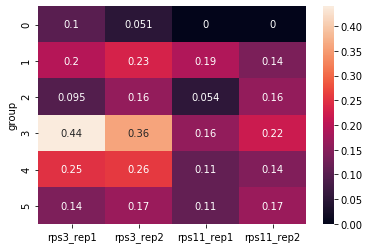

In [45]:
sns.heatmap(df.groupby(by = 'group').mean().iloc[:, 1:], annot = True)

In [46]:
df.groupby(by = 'group')['IDR'].value_counts().unstack().fillna(0)

IDR,no_rps11,no_rps3,yes_rps11,yes_rps3
group,,,,
0,19.0,20.0,0.0,0.0
1,135.0,129.0,7.0,394.0
2,56.0,76.0,1.0,14.0
3,45.0,43.0,1.0,11.0
4,124.0,123.0,19.0,81.0
5,25.0,46.0,0.0,0.0


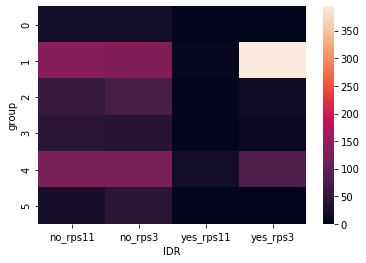

In [47]:
sns.heatmap(df.groupby(by = 'group')['IDR'].value_counts().unstack().fillna(0))

In [48]:
df.loc[df['IDR'] == 'no_rps3', ['rps3_rep1', 'rps3_rep2', 'group']].groupby('group').mean()

,rps3_rep1,rps3_rep2
group,,
0,0.100000,0.050000
1,0.503876,0.589147
2,0.092105,0.157895
3,0.511628,0.395349
4,0.365854,0.382114
5,0.108696,0.130435


In [49]:
df.loc[df['IDR'] == 'no_rps11', ['rps11_rep1', 'rps11_rep2', 'group']].groupby('group').mean()

,rps11_rep1,rps11_rep2
group,,
0,0.000000,0.000000
1,0.325926,0.192593
2,0.071429,0.214286
3,0.155556,0.266667
4,0.161290,0.217742
5,0.160000,0.240000


In [50]:
def plot_group_density(group, ax, norm = False):
    g = df.loc[df['group'] == group]
    for i in g.index:
        if 'rps3' in g.loc[i,'IDR']:
            
            shape = RPS3.values(g.loc[i, 'genomic pos'][0], g.loc[i, 'genomic pos'][1], g.loc[i, 'genomic pos'][2], g.loc[i, 'genomic pos'][3])
        else:
            shape = RPS11.values(g.loc[i, 'genomic pos'][0], g.loc[i, 'genomic pos'][1], g.loc[i, 'genomic pos'][2], g.loc[i, 'genomic pos'][3])
        
        if g.loc[i, 'genomic pos'][3] == '-':
            shape = [-s for s in shape]
        # fillna 0
        shape = np.nan_to_num(shape,0)
        
        if norm == True:
            shape = shape/np.sum(shape)
            ax.set_ylabel('read density, normed')
        else:
            ax.set_ylabel('read density')
        ax.plot(shape, color = 'grey', alpha = 0.5)
        ax.set_title('group: {}'.format(group))
        ax.set_xlabel('exon position')
        

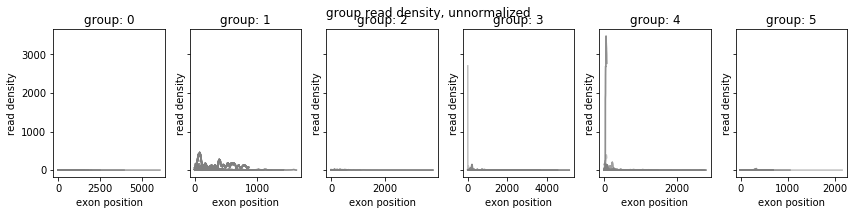

In [53]:
f, ax = plt.subplots(1,6, figsize = (12,3), sharey = True)
for gr in range(6):
    plot_group_density(gr, ax[gr], norm = False)
plt.suptitle('group read density, unnormalized')
plt.tight_layout()

/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/home/hsher/miniconda3/lib/p

Text(0.5, 0.98, 'group read density, unnormalized')

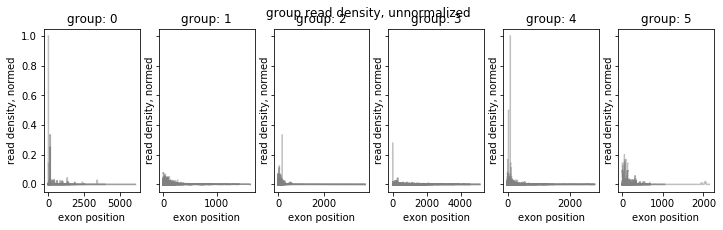

In [54]:
f, ax = plt.subplots(1,6, figsize = (12,3), sharey = True)
for gr in range(6):
    plot_group_density(gr, ax[gr], norm = True)
plt.suptitle('group read density, normalized')

# Case study on individual cases (IDR = False, indv = True)

In [83]:
df.loc[(df['IDR'].str.contains('no')) & (df['group']==1) &(~df['rps3_rep1']) &(~df['rps3_rep2'])]

,group,IDR,length,genomic pos,rps3_rep1,rps3_rep2,rps11_rep1,rps11_rep2
534,1,no_rps3,207,"(chr1, 633534, 633741, +)",False,False,False,False
535,1,no_rps3,207,"(chr1, 633534, 633741, +)",False,False,False,False
550,1,no_rps3,121,"(chr1, 956094, 956215, -)",False,False,False,False
556,1,no_rps3,140,"(chr1, 951999, 952139, -)",False,False,True,True
601,1,no_rps3,48,"(chr1, 1035276, 1035324, +)",False,False,False,False
...,...,...,...,...,...,...,...,...
1248,1,no_rps11,161,"(chr1, 1628018, 1628179, +)",False,False,False,False
1250,1,no_rps11,182,"(chr1, 1629384, 1629566, +)",False,False,False,False
1321,1,no_rps11,231,"(chr1, 2306019, 2306250, +)",False,False,False,False
1343,1,no_rps11,88,"(chr1, 2514001, 2514089, -)",False,False,False,False


In [91]:

def plot_one_density(i, norm = False, g = df):
             
    shape3 = RPS3.values(g.loc[i, 'genomic pos'][0], g.loc[i, 'genomic pos'][1], g.loc[i, 'genomic pos'][2], g.loc[i, 'genomic pos'][3])
    shape11 = RPS11.values(g.loc[i, 'genomic pos'][0], g.loc[i, 'genomic pos'][1], g.loc[i, 'genomic pos'][2], g.loc[i, 'genomic pos'][3])
        
    if g.loc[i, 'genomic pos'][3] == '-':
        shape3 = [-s for s in shape3]
        shape11 = [-s for s in shape11]
    # fillna 0
    shape3 = np.nan_to_num(shape3,0)
    shape11 = np.nan_to_num(shape11,0)
    
    plt.plot(shape3, color = 'olive', alpha = 0.5,label = 'RPS3')
    plt.plot(shape11, color = 'gold', alpha = 0.5,label = 'RPS11')
    plt.title('exon: {}'.format(' '.join([str(a) for a in list(g.loc[i, 'genomic pos'])])))
    plt.xlabel('exon position')
    plt.legend()
        

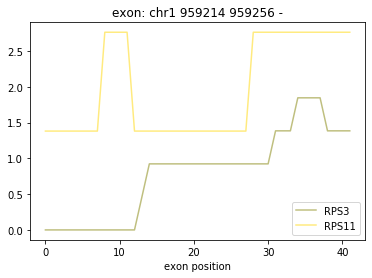

In [92]:
plot_one_density(545)

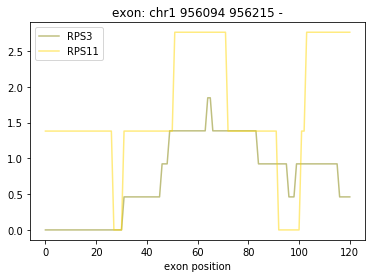

In [93]:
plot_one_density(550)

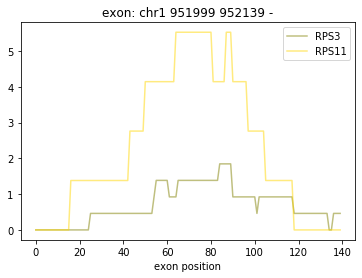

In [94]:
plot_one_density(556)

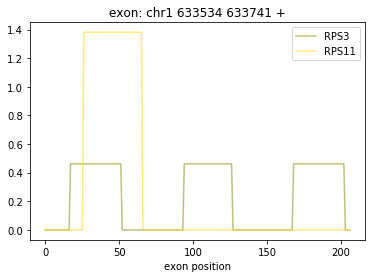

In [95]:
plot_one_density(534) 

In [75]:
rpm_to_read(rpm)

RPS3.total_mapped()

4334718

In [79]:
1.75*4334718/1000000

7.5857565

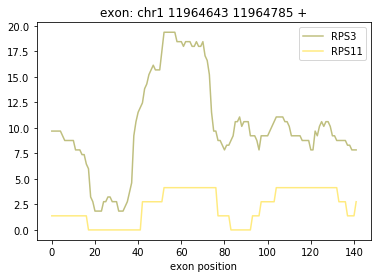

In [96]:
plot_one_density(88) 

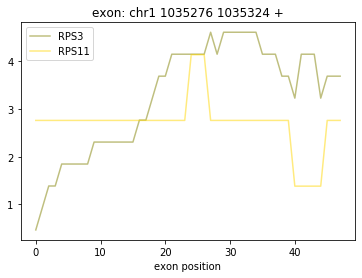

In [97]:
plot_one_density(601)

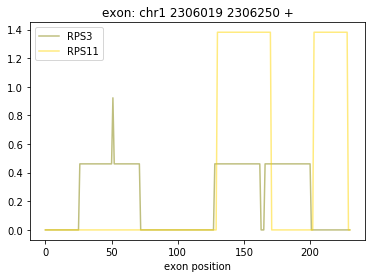

In [98]:
plot_one_density(1321)

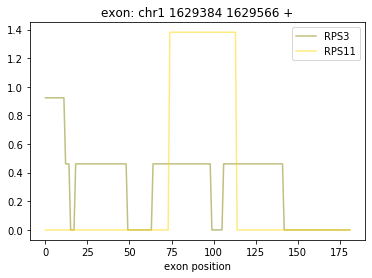

In [99]:
plot_one_density(1250)

In [100]:
df.loc[(df['IDR'].str.contains('no')) & (df['group']==3) &(~df['rps3_rep1']) &(~df['rps3_rep2'])]

,group,IDR,length,genomic pos,rps3_rep1,rps3_rep2,rps11_rep1,rps11_rep2
539,3,no_rps3,547,"(chr1, 634375, 634922, +)",False,False,False,False
540,3,no_rps3,547,"(chr1, 634375, 634922, +)",False,False,False,False
578,3,no_rps3,757,"(chr1, 964962, 965719, +)",False,False,False,False
579,3,no_rps3,757,"(chr1, 964962, 965719, +)",False,False,False,False
590,3,no_rps3,2086,"(chr1, 995965, 998051, -)",False,False,False,False
645,3,no_rps3,1165,"(chr1, 1081822, 1082987, -)",False,False,False,False
646,3,no_rps3,1165,"(chr1, 1081822, 1082987, -)",False,False,False,False
648,3,no_rps3,1318,"(chr1, 1142738, 1144056, +)",False,False,False,False
719,3,no_rps3,1656,"(chr1, 1327240, 1328896, +)",False,False,False,False
720,3,no_rps3,1656,"(chr1, 1327240, 1328896, +)",False,False,False,False


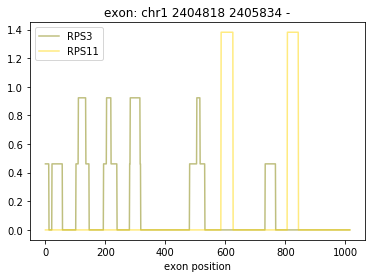

In [101]:
plot_one_density(1334)

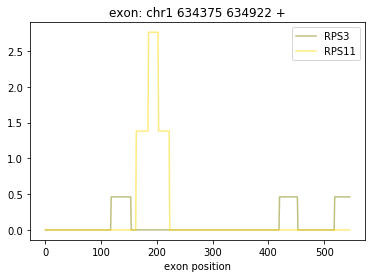

In [103]:
plot_one_density(977)

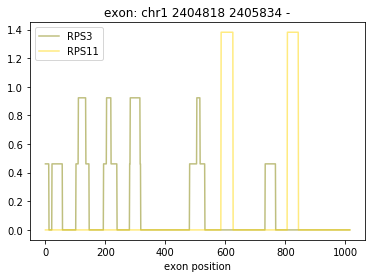

In [104]:
plot_one_density(1334)

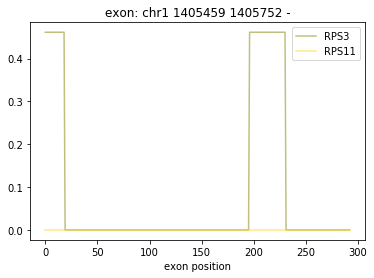

In [105]:
plot_one_density(775)

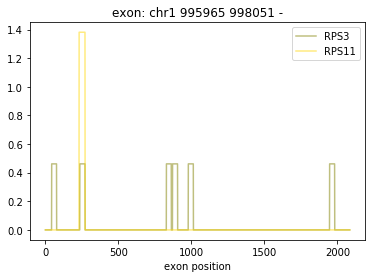

In [106]:
plot_one_density(590)